# STORM
### Synthesis of Topic Outlines through Retrieval and Multi-perspective question asking.

Research assistant that extends the idea of 'outline-driven RAG' for richer article generation.

It applies two main insights to produce more organized and comprehensive articles:
1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.

#### Overview
1. Generate initial outline + survey related subjects
2. Identify distiinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article

The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

Hyperparameters to restrict the potentially infinite research breadth:
- N: number of perspectives to survey
- M: Max number of conversation turns

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Select LLMs
We will have a faster LLM to do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [2]:
from langchain_openai import ChatOpenAI

FAST_LLM = ChatOpenAI(model='gpt-3.5-turbo')
GOOD_LLM = ChatOpenAI(model='gpt-4o')

### Generate Initial Outline
For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial outline to be referred after our research. Below, we will use our 'fast' llm to generate the outline.

In [3]:
import json

from langgraph.graph import END, StateGraph, START

from langchain_core.tools import tool
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.runnables import RunnableLambda, RunnableConfig, chain as as_runnable

from typing import List, Optional, Annotated, TypedDict

In [4]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a an experienced equity research analyst. Write an outline for an analysis report about a user-provided topic. Be comprehensive and specific.'
        ),
        ('user', '{topic}')
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title='Content of the subsection')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.description}'.strip()
    

class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title='Content of the section')
    subsections: Optional[List[Subsection]] = Field(default=None, title='Titles and descriptions for each subsection of the analysis report.')

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(f'### {subsection.subsection_title}\n\n{subsection.description}' for subsection in self.subsections or [])
        return f'## {self.section_title}\n\n{self.description}\n\n{subsections}'.strip()
    

class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Report')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Report page.'
    )

    @property
    def as_str(self) -> str:
        sections = '\n\n'.join(section.as_str for section in self.sections)
        return f'# {self.page_title}\n\n{sections}'.strip()
    
generate_outline_direct = direct_gen_outline_prompt | FAST_LLM.with_structured_output(Outline)

In [5]:
example_topic = 'Impact on silicon industry due to the China Taiwan war'

In [6]:
initial_outline = generate_outline_direct.invoke({'topic': example_topic})

In [7]:
print(initial_outline.as_str)

# Analysis Report: Impact on Silicon Industry due to China-Taiwan Conflict

## Introduction

Brief overview of the China-Taiwan conflict and its potential implications on the silicon industry.

## Background of the Silicon Industry

Overview of the global silicon industry, key players, market size, and growth trends.

## Current Market Dynamics

Analysis of the current market conditions in the silicon industry pre-conflict.

## Potential Supply Chain Disruptions

Assessment of potential supply chain disruptions in the silicon industry due to the China-Taiwan conflict.

## Impact on Key Players

Evaluation of how major players in the silicon industry may be affected by the conflict.

## Market Volatility and Investment Opportunities

Discussion on the potential market volatility and investment opportunities in the silicon industry.

## Government Policies and Regulatory Changes

Analysis of how government policies and regulatory changes may impact the silicon industry in response to the

### Expand topics
While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [20]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    '''I'm writing a financial report for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.
    Please list as many subjects and urls as you can.

    Topic of interest: {topic}''')

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(description='Comprehensive list of related subjects as background research')

expand_chain = gen_related_topics_prompt | FAST_LLM.with_structured_output(RelatedSubjects)

In [21]:
related_subjects = await expand_chain.ainvoke({'topic': example_topic})
related_subjects

RelatedSubjects(topics=['Silicon industry', 'China-Taiwan conflict', 'Technology impact', 'Economic impact'])

### Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as 'subject matter experts' with distinct backgrounds and affiliations. These will help distribute the research process to encourage a more well-rounded final report.

In [22]:
class Editor(BaseModel):
    affiliation: str = Field(description='Primary affiliation of the editor.')
    name: str = Field(description='Name of the editor', pattern=r'^[a-zA-Z0-9_-]{1,64}$')
    role: str = Field(description='Role of the editor in the context of the topic.')
    description: str = Field(description='Description of the editor\'s focus, concerns and motives')

    @property
    def persona(self) -> str:
        return f'Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n'
    

class Perspectives(BaseModel):
    editors: List[Editor] = Field(description='Comprehensive list of editors with their roles and affiliations.')


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You need to select a diverse (and distinct) group of equity research analysts, equity researchers and editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic. 
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on. 
            
            Wiki pages outlines of related topics for inspiration: 
            {examples}''',
        ),
        (
            'user'
            'Topic of interest: {topic}'
        )
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | FAST_LLM.with_structured_output(Perspectives)

In [23]:
wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = '- '.join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return '\n\n'.join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({'topic': topic})
    retrieved_docs = await wikipedia_retriever.abatch(related_subjects.topics, return_exceptions=True)
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({'examples': formatted, 'topic': topic})

In [25]:
perspectives = await survey_subjects.ainvoke(example_topic)

editors=[Editor(affiliation='Equity Research Firm', name='AliceSmith', role='Equity Research Analyst', description='Alice will focus on analyzing the potential impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market sentiment, and stock performance of key companies in the sector.'), Editor(affiliation='Tech News Outlet', name='JohnDoe', role='Tech Editor', description='John will provide insights on the technological advancements in the silicon industry and how the conflict may influence innovation, research, and development in the sector.'), Editor(affiliation='Global Economic Magazine', name='EmmaBrown', role='Economic Analyst', description='Emma will examine the macroeconomic implications of the China-Taiwan conflict on the global silicon industry, including trade dynamics, investment trends, and economic forecasts.')]


In [26]:
perspectives.dict()

{'editors': [{'affiliation': 'Equity Research Firm',
   'name': 'AliceSmith',
   'role': 'Equity Research Analyst',
   'description': 'Alice will focus on analyzing the potential impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market sentiment, and stock performance of key companies in the sector.'},
  {'affiliation': 'Tech News Outlet',
   'name': 'JohnDoe',
   'role': 'Tech Editor',
   'description': 'John will provide insights on the technological advancements in the silicon industry and how the conflict may influence innovation, research, and development in the sector.'},
  {'affiliation': 'Global Economic Magazine',
   'name': 'EmmaBrown',
   'role': 'Economic Analyst',
   'description': 'Emma will examine the macroeconomic implications of the China-Taiwan conflict on the global silicon industry, including trade dynamics, investment trends, and economic forecasts.'}]}

### Expert Dialog
Each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generates content to generate a refined outline as well as an updated index of reference documents.

### Interview State
The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [27]:
def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

### Dialog roles
The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [28]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an experienced equity research analyst with great critical thinking skills. 
            You want to edit a specific report. 
            Besides your exceptional writing skills, you have a specific focus when researching the topic. 
            Now you are chatting with an expert to get information. Ask good questions to get more useful information. 
            Make sure to get answers for specific industries, specific companies or ticker symbols and verticals within companies, as and when relevant. 
            
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation. 
            Please only ask one question at a time and don't ask what you have asked before. 
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.
            
            Stay true to your specific perspective: 
            
            {persona}''',
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={'type'}))
        converted.append(message)
    return {'messages': converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state['editor']
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | FAST_LLM
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {'messages': [result]}

In [29]:
messages = [
    HumanMessage(f'So you said you were writing an article on {example_topic}?')
]

question = await generate_question.ainvoke(
    {
        'editor': perspectives.editors[0],
        'messages': messages
    }
)

question['messages'][0].content

"Yes, that's correct. I am analyzing the potential impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market sentiment, and stock performance of key companies in the sector. Do you have any insights on how this conflict might affect specific companies within the silicon industry?"

### Answer Questions
The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [32]:
class Queries(BaseModel):
    queries: List[str] = Field(description='Comprehensive list of search engine queries to answer the user\'s question')

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a helpful equity research assistant. Query the search engine to answer the user\'s questions.'
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)
gen_queries_chain = gen_queries_prompt | GOOD_LLM.with_structured_output(Queries, include_raw=True)

In [33]:
queries = await gen_queries_chain.ainvoke({'messages': [HumanMessage(content=question['messages'][0].content)]})
queries['parsed'].queries

['impact of China-Taiwan conflict on silicon industry',
 'China-Taiwan conflict effect on silicon supply chain',
 'market sentiment on silicon stocks due to China-Taiwan tensions',
 'China-Taiwan conflict and stock performance of silicon companies',
 'key silicon companies affected by China-Taiwan conflict']

In [39]:
class AnswersWithCitations(BaseModel):
    answer: str = Field(description='Comprehensive answer to the user\'s question with citations.')
    cited_urls: List[str] = Field(
        description='List of urls cited in the answer.',
    )

    @property
    def as_str(self) -> str:
        return f'{self.answer}\n\nCitations:\n\n' + '\n'.join(
            f'[{i+1}: {url}]' for i, url in enumerate(self.cited_urls)
        )
    
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an expert equity research analyst who can use information effectively. 
            You are chatting with an equity research report writer who wants to write an analysis report on the topic you know. 
            You have gathered the related information and will now use the information to form a response. 
            
            Make your response as informative as possible and make sure every sentence is supported by the gathered information. 
            Be sure to mention specific industries, companies and verticals within companies as required. 
            Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLs after your response.'''
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

gen_answer_chain = gen_answer_prompt | GOOD_LLM.with_structured_output(AnswersWithCitations, include_raw=True).with_config(run_name='GenerateAnswer')

In [40]:
# Tavily is typically a better search engine but free queries are limited.
# search_engine = TavilySearchResults(max_results=4)

# @tool
# async def search_engine(query: str):
#     '''Search engine to the internet'''
#     results = tavily_search.invoke(query)
#     return [{'content': r['content'], 'url': r['url']} for r in results]

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    '''Search engine to the internet'''
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{'content': r['body'], 'url': r['href']} for r in results]

In [41]:
async def gen_answer(state: InterviewState, config: Optional[RunnableConfig]=None, name: str='subject_matter_expert', max_str_len: int=15000):
    swapped_state = swap_roles(state, name) # convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(queries['parsed'].queries, config, return_exceptions=True)
    successful_results = [res for res in query_results if not isinstance(res, Exception)]
    all_query_results = {res['url']: res['content'] for results in successful_results for res in results}

    # we could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].additional_kwargs['tool_calls'][0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state['messages'].extend([ai_message, tool_message])

    # only update the shared state with the final answer to avoid polluting the dialog history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)

    # save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)
    return {'messages': [formatted_message], 'references': cited_references}

In [42]:
example_answer = await gen_answer(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

In [43]:
print(example_answer['messages'][-1].content)

The China-Taiwan conflict poses significant risks to the silicon industry, impacting supply chains, market sentiment, and the stock performance of key companies. Taiwan is a critical hub for semiconductor manufacturing, with companies like Taiwan Semiconductor Manufacturing Company (TSMC) being central to the global supply of advanced chips. TSMC alone produces about 90% of the world's most advanced semiconductors[^1^]. Any disruption in Taiwan due to geopolitical tensions could severely impact global tech industries reliant on these chips, including sectors like consumer electronics, automotive, and telecommunications[^2^]. This dependency creates vulnerabilities, as highlighted by the global disruptions during the COVID-19 pandemic[^3^]. For instance, an escalation in the China-Taiwan conflict could force companies to activate contingency plans, significantly disrupting production and supply chains[^4^]. Additionally, US-China tensions have already led to export controls on advanced 

### Construct the Interview Graph

In [44]:
max_num_turns = 5

def route_messages(state: InterviewState, name: str='subject_matter_expert'):
    messages = state['messages']
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]

    if last_question.content.endswith('Thank you so much for your help!'):
        return END
    
    return 'ask_question'

builder = StateGraph(InterviewState)

builder.add_node('ask_question', generate_question)
builder.add_node('answer_question', gen_answer)
builder.add_conditional_edges('answer_question', route_messages)
builder.add_edge('ask_question', 'answer_question')
builder.add_edge(START, 'ask_question')
interview_graph = builder.compile().with_config(run_name='Conduct Interviews')

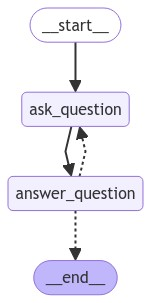

In [47]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(Image(interview_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [54]:
final_step = None

initial_state = {
    'editor': perspectives.editors[0],
    'messages': [
        AIMessage(
            content=f'So you said you were writing an article on {example_topic}?',
            name='subject_matter_expert'
        )
    ]
}

async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print('--', str(step[name]['messages'])[:300])
    if END in step:
        final_step = step

ask_question
-- [AIMessage(content="Yes, that's correct. I am focusing on analyzing the potential impact of the China-Taiwan conflict on the silicon industry, including supply chain disruptions, market sentiment, and stock performance of key companies in the sector. Do you have any insights on how this conflict mig
answer_question
-- [AIMessage(content="The China-Taiwan conflict poses significant risks to the global silicon industry, particularly concerning supply chain disruptions. Taiwan is a crucial hub in the semiconductor supply chain, accounting for over 60% of the world's semiconductor production, including 70% of all chi
ask_question
-- [AIMessage(content='That was very insightful. Thank you for providing a detailed overview of how the China-Taiwan conflict could impact the silicon industry, particularly in terms of supply chain disruptions. \n\nGiven the potential risks outlined, do you have any specific insights on how market sen
answer_question
-- [AIMessage(content="The esc

In [58]:
final_state = next(iter(step.values()))

In [63]:
final_state['messages'][0].content

"The China-Taiwan conflict poses significant risks to the global silicon industry, particularly concerning supply chain disruptions, market sentiment, and stock performance of key companies like Taiwan Semiconductor Manufacturing Company (TSMC). Taiwan is a crucial hub in the semiconductor supply chain, accounting for over 60% of the world's semiconductor production, including 70% of all chips smaller than 7 nanometers.[1] Companies like TSMC are central to this dominance, producing about 90% of the world's most advanced chips.[2] A conflict could severely disrupt this supply chain, affecting not only production but also the global distribution of chips. TSMC and other firms have contingency plans to disable chip manufacturing should an invasion occur, exacerbating the shortage of advanced semiconductors worldwide.[3] The geopolitical tensions have led to shifts in investment and manufacturing, with Taiwan diversifying its investments into countries like Thailand, Vietnam, and Malaysia